In [1]:
import gym
from gym import spaces

import warnings
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines.common.policies import MlpPolicy
from stable_baselines.deepq.policies import MlpPolicy as DQN_MlpPolicy
from stable_baselines import A2C, PPO2, DQN
from stable_baselines.common.vec_env import DummyVecEnv, SubprocVecEnv

from aequam_env import AequamEnv
from fpdf import FPDF

In [2]:
def rescale(df, start_int = 0, base = 100):
    return(df/np.array(df.iloc[start_int,:])*base)

In [3]:
df_obs_1 = pd.read_csv('data/dataset1.csv', index_col = 0, parse_dates=True, usecols = lambda x: x not in ['Equi_weighted'])
df_obs_2 = pd.read_csv('data/dataset1.csv', index_col = 0, parse_dates=True, usecols = lambda x: x not in ['Equi_weighted'])
df_obs_3 = pd.read_csv('data/dataset1.csv', index_col = 0, parse_dates=True, usecols = lambda x: x not in ['Equi_weighted'])
df_obs_4 = pd.read_csv('data/dataset1.csv', index_col = 0, parse_dates=True, usecols = lambda x: x not in ['Equi_weighted'])
df_obs_5 = pd.read_csv('data/dataset1.csv', index_col = 0, parse_dates=True, usecols = lambda x: x not in ['Equi_weighted'])
df_obs_6 = pd.read_csv('data/dataset1.csv', index_col = 0, parse_dates=True, usecols = lambda x: x not in ['Equi_weighted'])
df_obs_7 = pd.read_csv('data/dataset1.csv', index_col = 0, parse_dates=True, usecols = lambda x: x not in ['Equi_weighted'])

def propagate_index(from_df, to_df):
    return(to_df.loc[from_df.index,:])

df_prices_base = pd.read_csv('data/test.csv', index_col = 0, parse_dates=True, usecols = [i for i in range(7)])

df_prices_all = df_prices_base.copy()
df_prices_on_off = pd.DataFrame(df_prices_base.mean(axis=1), columns = ['Equally_weighted'])
df_prices_modes = pd.concat([df_prices_base[['Value','Momentum','Carry']].mean(axis=1), \
                            df_prices_on_off,\
                            df_prices_base[['Quality','Profitability','Size']].mean(axis=1) ], axis=1)
df_prices_modes.columns = ['Offensive','Equally_weighted','Defensive']

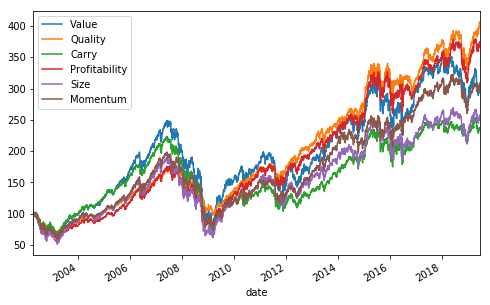

In [4]:
# plt.figure()
rescale(df_prices_base).iloc[::1,:].plot(figsize=(8,5))
plt.show()

In [76]:
warnings.filterwarnings('ignore')

n_filter = 1
# n_episodes = 100
lookback_window = 20
reward_type = 'delayed'
total_timesteps = 300
transaction_smoothing = 2
algo = 'dqn'

df_obs = df_obs_6.copy()
df_prices = propagate_index(from_df=df_obs, to_df=df_prices_modes)

env = DummyVecEnv([lambda: AequamEnv(df_obs.iloc[::n_filter], df_prices.iloc[::n_filter],\
                                     lookback_window = lookback_window, reward_type = reward_type,\
                                     transaction_smoothing = transaction_smoothing)])

In [77]:
# env = Monitor(AequamEnv(df_obs.iloc[::n_filter], df_prices.iloc[::n_filter],\
#                         lookback_window = 5), log_dir, allow_early_resets=True)

# env = AequamEnv(df_obs.iloc[::50], df_prices.iloc[::50])
if algo == 'dqn':   
    model = DQN(DQN_MlpPolicy, env, param_noise=True, verbose=1, tensorboard_log='tmp/')
elif algo == 'ppo2' :   
    model = PPO2(MlpPolicy, env, verbose=1, tensorboard_log='tmp/')
#     total_timesteps *= 100
else:
    print(1/0)
    

In [78]:
model.learn(total_timesteps=total_timesteps)

#DQN
# (total_timesteps, callback=None, seed=None, log_interval=100, tb_log_name='DQN', reset_num_timesteps=True, replay_wrapper=None)

# obs = env.reset()
# done = False

# for i in range(n_episodes):
#     while not done:
#         action, _states = model.predict(obs)
#         obs, rewards, done, info = env.step(action)
# #         env.render(mode='human')

In [52]:
model.load('DQN_good_model.pkl')

Loading a model without an environment, this model cannot be trained until it has a valid environment.


In [79]:
obs, rewards, done, info = env.step(np.array([1]))

In [80]:
state=None; mask=None; deterministic=True


obs = env.reset()
for i in range(env.envs[0].total_window -env.envs[0].lookback_window-1):
#     i += 1
#     print(i)
#     import pdb;pdb.set_trace()
#     action, _states = model.predict(obs, deterministic=False)
    
    observation = np.array(obs)
    vectorized_env = model._is_vectorized_observation(observation, model.observation_space)

    observation = observation.reshape((-1,) + model.observation_space.shape)
    with model.sess.as_default():
        
        
        
#         actions, _, _ = model.step_model.step(observation, deterministic=deterministic)
        
        q_values, actions_proba = model.step_model.sess.run([model.step_model.q_values, model.step_model.policy_proba], {model.step_model.obs_ph: obs})
        print(actions_proba)
        print(q_values)
        if deterministic:
            actions = np.argmax(q_values, axis=1)
        else:
            # Unefficient sampling
            # TODO: replace the loop
            # maybe with Gumbel-max trick ? (http://amid.fish/humble-gumbel)
            actions = np.zeros((len(obs),), dtype=np.int64)
            for action_idx in range(len(obs)):
                actions[action_idx] = np.random.choice(model.step_model.n_actions, p=actions_proba[action_idx])
        actions, _, _ = actions, q_values, None

    if not vectorized_env:
        actions = actions[0]
    
    action, _states = actions, None
    
    obs, rewards, done, info = env.step(action)

[[nan nan nan nan]]
[[nan nan nan nan]]
[[0.25005373 0.24993488 0.24981514 0.25019628]]
[[ 0.00015925 -0.00031611 -0.00079535  0.0007292 ]]
[[0.25008437 0.24990591 0.24984877 0.25016096]]
[[ 0.00053384 -0.00018    -0.00040871  0.00084005]]
[[0.25003874 0.24985981 0.2498556  0.2502459 ]]
[[ 0.00044825 -0.0002677  -0.00028453  0.00127637]]
[[0.2501253  0.24984707 0.2498048  0.25022292]]
[[ 0.00088884 -0.00022409 -0.00039329  0.00127912]]
[[0.250107   0.24987015 0.2497888  0.250234  ]]
[[ 8.8586658e-04 -6.1506958e-05 -3.8715175e-04  1.3935894e-03]]
[[0.25009486 0.24990107 0.24981461 0.25018945]]
[[ 8.4126124e-04  6.6118024e-05 -2.7991872e-04  1.2194138e-03]]
[[0.25007132 0.24988322 0.24984986 0.25019556]]
[[ 0.00065186 -0.00010062 -0.00023413  0.00114859]]
[[0.25000465 0.24983092 0.2498746  0.25028986]]
[[ 0.00015233 -0.0005428  -0.000368    0.0012925 ]]
[[0.25003126 0.2498014  0.24985042 0.2503169 ]]
[[ 0.00017393 -0.00074585 -0.00054962  0.00131561]]
[[0.25006428 0.24980852 0.24982435 0

[[0.25041616 0.24998318 0.24969035 0.24991027]]
[[ 0.00189967  0.00016909 -0.00100292 -0.00012262]]
[[0.2504051  0.24992394 0.2497259  0.24994497]]
[[ 1.9065945e-03 -1.6762468e-05 -8.0953870e-04  6.7322806e-05]]
[[0.25037664 0.24995396 0.24973246 0.24993691]]
[[ 1.5999315e-03 -8.9662579e-05 -9.7619748e-04 -1.5792061e-04]]
[[0.25029662 0.24998419 0.24975525 0.24996397]]
[[ 1.21245545e-03 -3.65625965e-05 -9.52829141e-04 -1.17494994e-04]]
[[0.25028083 0.24996029 0.24975416 0.25000474]]
[[ 1.2213576e-03 -6.0207763e-05 -8.8515889e-04  1.1766565e-04]]
[[0.25017783 0.2499499  0.24983713 0.2500351 ]]
[[ 9.6794183e-04  5.6473626e-05 -3.9482155e-04  3.9727884e-04]]
[[0.2501098  0.24991673 0.24987826 0.25009522]]
[[ 0.0005438  -0.0002284  -0.00038237  0.00048553]]
[[0.25009993 0.24997027 0.24987902 0.25005075]]
[[ 5.6312577e-04  4.4537112e-05 -3.2052700e-04  3.6650436e-04]]
[[0.2500419  0.25005576 0.24988656 0.25001574]]
[[ 1.3760076e-04  1.9300205e-04 -4.8388599e-04  3.2915505e-05]]
[[0.2500717 

[[0.25003165 0.2498921  0.24988468 0.2501915 ]]
[[-0.00015768 -0.00071599 -0.00074567  0.00048144]]
[[0.25004137 0.2498895  0.2498815  0.2501876 ]]
[[-0.00018231 -0.00078989 -0.00082187  0.00040238]]
[[0.2500821  0.24986686 0.24982332 0.25022766]]
[[-0.00014178 -0.00100287 -0.0011771   0.00044009]]
[[0.25010234 0.249854   0.24980102 0.25024262]]
[[-7.7287958e-05 -1.0707945e-03 -1.2827590e-03  4.8342953e-04]]
[[0.25011566 0.24984755 0.2497962  0.25024065]]
[[ 1.0363525e-05 -1.0622602e-03 -1.2677468e-03  5.0993677e-04]]
[[0.25013146 0.24984671 0.24975258 0.25026923]]
[[ 8.7791763e-05 -1.0512430e-03 -1.4281232e-03  6.3843571e-04]]
[[0.25008523 0.24988158 0.2498032  0.25022998]]
[[-9.3568815e-07 -8.1560470e-04 -1.1293187e-03  5.7773525e-04]]
[[0.2500827  0.24988799 0.24981992 0.25020936]]
[[ 6.6358480e-05 -7.1259367e-04 -9.8502671e-04  5.7263498e-04]]
[[0.25008476 0.2498687  0.24982858 0.25021794]]
[[ 0.00017516 -0.00068905 -0.00084964  0.00070766]]
[[0.2500784  0.24984665 0.24983875 0.250

[[-6.9135451e-05 -2.2992973e-04 -2.8988620e-04  1.8302286e-04]]
[[0.24998698 0.24997996 0.24997634 0.25005668]]
[[-6.7851499e-05 -9.5924835e-05 -1.1042911e-04  2.1097779e-04]]
[[0.24999197 0.24996556 0.24996817 0.25007427]]
[[-7.8328892e-05 -1.8399641e-04 -1.7354796e-04  2.5078922e-04]]
[[0.24997523 0.24998139 0.24997309 0.25007033]]
[[-0.00012544 -0.00010082 -0.00013399  0.00025492]]
[[0.24998543 0.24998376 0.24997033 0.2500604 ]]
[[-7.6330092e-05 -8.2981249e-05 -1.3672502e-04  2.2361384e-04]]
[[0.24998595 0.24996668 0.2499826  0.2500648 ]]
[[-2.2223168e-05 -9.9215518e-05 -3.5622819e-05  2.9315555e-04]]
[[0.2499882  0.2499686  0.24997054 0.2500727 ]]
[[-2.4155888e-06 -8.0873986e-05 -7.3086849e-05  3.3545963e-04]]
[[0.24998032 0.2499837  0.24997729 0.25005862]]
[[-0.00012463 -0.00011115 -0.00013675  0.00018855]]
[[0.24998653 0.24998005 0.2499787  0.25005466]]
[[-7.8159399e-05 -1.0410079e-04 -1.0948884e-04  1.9431995e-04]]
[[0.2499961  0.24997962 0.24997689 0.25004742]]
[[-4.1285170e-05

[[0.25002193 0.24995041 0.24994501 0.25008264]]
[[3.5532581e-04 6.9243193e-05 4.7643378e-05 5.9814221e-04]]
[[0.25003037 0.24995187 0.24996303 0.25005463]]
[[3.5695735e-04 4.2940577e-05 8.7557855e-05 4.5395963e-04]]
[[0.2500154  0.24996166 0.2499596  0.25006336]]
[[3.16082820e-04 1.01125785e-04 9.29267990e-05 5.07903751e-04]]
[[0.25000733 0.24996229 0.24996854 0.2500619 ]]
[[ 1.4219427e-04 -3.7899597e-05 -1.2872661e-05  3.6049506e-04]]
[[0.250003   0.24997063 0.24994911 0.25007728]]
[[ 5.0985036e-05 -7.8535813e-05 -1.6460597e-04  3.4799724e-04]]
[[0.24999227 0.24997732 0.24995182 0.2500786 ]]
[[-2.7058632e-06 -6.2545245e-05 -1.6450911e-04  3.4249818e-04]]
[[0.2500105  0.24997665 0.24994054 0.25007233]]
[[ 9.4644762e-05 -4.0719642e-05 -1.8519530e-04  3.4192603e-04]]
[[0.25000042 0.24998493 0.2499452  0.25006947]]
[[ 2.0060447e-04  1.3864327e-04 -2.0367850e-05  4.7673678e-04]]
[[0.24999285 0.24999201 0.2499711  0.25004405]]
[[1.6127671e-04 1.5792980e-04 7.4286465e-05 3.6602444e-04]]
[[0.

[[0.25009906 0.24995162 0.24990062 0.25004867]]
[[ 0.00044241 -0.00014731 -0.00035139  0.00024089]]
[[0.25010133 0.24995512 0.24991238 0.2500311 ]]
[[ 0.00043529 -0.00014951 -0.0003205   0.00015453]]
[[0.2500946  0.24996161 0.2499145  0.25002924]]
[[ 0.00038763 -0.00014427 -0.00033274  0.00012625]]
[[0.25007728 0.24995714 0.2499334  0.25003216]]
[[ 0.00031621 -0.00016434 -0.00025923  0.00013576]]
[[0.25007465 0.2499502  0.24993697 0.25003818]]
[[ 0.00032234 -0.0001755  -0.00022836  0.00017648]]
[[0.25007263 0.24996129 0.24993269 0.25003335]]
[[ 0.00033578 -0.00010958 -0.00022397  0.00017865]]
[[0.2500521  0.24996325 0.24994196 0.25004268]]
[[ 2.9104855e-04 -6.4315333e-05 -1.4949127e-04  2.5339343e-04]]
[[0.25005466 0.24996343 0.2499541  0.25002778]]
[[ 3.1488930e-04 -5.0043323e-05 -8.7315435e-05  2.0742223e-04]]
[[0.25006554 0.2499595  0.24993534 0.2500396 ]]
[[ 3.4126916e-04 -8.2847837e-05 -1.7949406e-04  2.3759846e-04]]
[[0.2500529  0.24995635 0.2499508  0.25003988]]
[[ 2.86739465e-0

[[0.2500422  0.25001362 0.24995008 0.24999405]]
[[ 2.1415384e-04  9.9810997e-05 -1.5431983e-04  2.1619147e-05]]
[[0.25005525 0.24999912 0.24994594 0.24999963]]
[[ 2.7247774e-04  4.8010967e-05 -1.6473263e-04  5.0029274e-05]]
[[0.25004938 0.24998687 0.24995825 0.25000548]]
[[ 2.5593600e-04  5.9313097e-06 -1.0860088e-04  8.0396538e-05]]
[[0.2500548  0.24998085 0.24996041 0.25000396]]
[[ 3.7603089e-04  8.0243488e-05 -1.5714031e-06  1.7270482e-04]]
[[0.2500528  0.2499901  0.24996531 0.24999179]]
[[ 1.9102205e-04 -5.9786700e-05 -1.5898164e-04 -5.3050895e-05]]
[[0.25006485 0.24999246 0.24994974 0.24999304]]
[[ 3.0015287e-04  1.0617616e-05 -1.6027520e-04  1.2947654e-05]]
[[0.25008413 0.24998099 0.2499402  0.24999472]]
[[ 3.8525733e-04 -2.7321286e-05 -1.9042607e-04  2.7666021e-05]]
[[0.25007856 0.24999037 0.24994285 0.24998826]]
[[ 4.1818939e-04  6.5511907e-05 -1.2459571e-04  5.7058729e-05]]
[[0.25007635 0.2499931  0.24993975 0.24999082]]
[[ 3.7987073e-04  4.6919893e-05 -1.6648337e-04  3.782851

[[0.2500697  0.24998988 0.24991898 0.2500214 ]]
[[ 2.3119959e-04 -8.8117478e-05 -3.7169960e-04  3.7995062e-05]]
[[0.2500699  0.24997555 0.24992025 0.25003427]]
[[ 0.00024495 -0.00013238 -0.00035362  0.00010256]]
[[0.25006726 0.24997643 0.2499216  0.25003466]]
[[ 0.00025691 -0.00010636 -0.00032571  0.00012652]]
[[0.25007442 0.24997863 0.24991705 0.25002986]]
[[ 2.2098959e-04 -1.6211491e-04 -4.0851213e-04  4.2805856e-05]]
[[0.25007787 0.24997616 0.24991097 0.25003502]]
[[ 0.00030045 -0.00010636 -0.00036723  0.00012899]]
[[0.25008148 0.2499684  0.24991064 0.25003955]]
[[ 3.7661259e-04 -7.5732634e-05 -3.0674954e-04  2.0884718e-04]]
[[0.2500801  0.24996534 0.24990217 0.25005242]]
[[ 3.9096209e-04 -6.8084431e-05 -3.2076403e-04  2.8023345e-04]]
[[0.25008127 0.24995977 0.24991994 0.25003907]]
[[ 0.00037602 -0.00010996 -0.00026928  0.00020721]]
[[0.25007415 0.24996434 0.24991554 0.25004593]]
[[ 0.00027373 -0.00016547 -0.00036072  0.0001609 ]]
[[0.25005674 0.24997748 0.24991024 0.25005552]]
[[ 2

[[0.25004014 0.25000915 0.24992476 0.25002593]]
[[ 0.00030737  0.00018347 -0.0001542   0.00025049]]
[[0.2500288  0.2500082  0.24991037 0.2500526 ]]
[[ 0.00024303  0.00016068 -0.00023068  0.0003383 ]]
[[0.25002068 0.2500157  0.24992089 0.25004268]]
[[ 3.1251379e-04  2.9264495e-04 -8.6751330e-05  4.0045861e-04]]
[[0.25002754 0.24997988 0.24995163 0.2500409 ]]
[[ 2.3333548e-04  4.2699234e-05 -7.0343114e-05  2.8668609e-04]]
[[0.2500963  0.24998663 0.24986973 0.25004733]]
[[ 0.00054983  0.00011127 -0.00035646  0.00035399]]
[[0.25007546 0.24994533 0.24990895 0.25007024]]
[[ 0.00035522 -0.00016529 -0.00031084  0.00033435]]
[[0.25006756 0.24994653 0.24991097 0.25007492]]
[[ 3.8459347e-04 -9.9554141e-05 -2.4188485e-04  4.1395170e-04]]
[[0.2500625  0.2499412  0.24992888 0.2500674 ]]
[[5.7715666e-04 9.1951631e-05 4.2674859e-05 5.9678388e-04]]
[[0.25009128 0.24994053 0.24991722 0.2500509 ]]
[[ 6.6470954e-04  6.1753788e-05 -3.1550182e-05  5.0315767e-04]]
[[0.2500433  0.2499533  0.24994962 0.2500537

[[0.25000724 0.24998531 0.24998306 0.25002444]]
[[-1.0592142e-04 -1.9375082e-04 -2.0276089e-04 -3.7221092e-05]]
[[0.250004   0.24999654 0.2499729  0.25002658]]
[[-2.6830094e-05 -5.6630779e-05 -1.5122729e-04  6.3539133e-05]]
[[0.25001281 0.249989   0.24995404 0.25004414]]
[[ 3.7336787e-05 -5.7912748e-05 -1.9779151e-04  1.6258548e-04]]
[[0.25000373 0.2499882  0.24995928 0.2500488 ]]
[[ 1.5130825e-05 -4.6955422e-05 -1.6263573e-04  1.9539447e-04]]
[[0.2500216  0.24998623 0.24994987 0.25004232]]
[[ 1.2948217e-04 -1.1984954e-05 -1.5747770e-04  2.1233810e-04]]
[[0.25002298 0.2499868  0.24992989 0.25006026]]
[[ 1.7392954e-04  2.9206978e-05 -1.9849591e-04  3.2302749e-04]]
[[0.25002572 0.24999423 0.24993086 0.25004914]]
[[ 1.5107245e-04  2.5118239e-05 -2.2838559e-04  2.4475410e-04]]
[[0.25004238 0.24999136 0.24993081 0.25003552]]
[[ 2.0576580e-04  1.7113489e-06 -2.4050742e-04  1.7837211e-04]]
[[0.25002703 0.24999471 0.24993308 0.25004518]]
[[ 7.1302857e-05 -5.7984224e-05 -3.0457781e-04  1.438784

[[0.25000194 0.24997619 0.24997847 0.25004336]]
[[ 4.7753892e-05 -5.5193123e-05 -4.6080568e-05  2.1349703e-04]]
[[0.25002056 0.24997175 0.24996042 0.25004724]]
[[ 1.5768369e-04 -3.7618185e-05 -8.2936429e-05  2.6434389e-04]]
[[0.2500189  0.24998412 0.24995561 0.2500413 ]]
[[ 1.4205117e-04  3.0054653e-06 -1.1106630e-04  2.3172624e-04]]
[[0.25004724 0.2499846  0.24994393 0.2500243 ]]
[[ 3.4296396e-04  9.2503004e-05 -7.0275390e-05  2.5121964e-04]]
[[0.25006092 0.24997625 0.24995852 0.2500043 ]]
[[4.4769363e-04 1.0900543e-04 3.8126251e-05 2.2115713e-04]]
[[0.25005743 0.24998708 0.24995191 0.25000358]]
[[ 4.1734532e-04  1.3598327e-04 -4.6770874e-06  2.0199265e-04]]
[[0.25006345 0.24997877 0.24995862 0.24999925]]
[[4.5752997e-04 1.1879108e-04 3.8219572e-05 2.0080931e-04]]
[[0.25007057 0.24997911 0.24995597 0.24999434]]
[[5.4141250e-04 1.7558289e-04 8.2990649e-05 2.3648096e-04]]
[[0.25005412 0.24998997 0.249961   0.24999483]]
[[0.00051073 0.00025416 0.00013827 0.0002736 ]]
[[0.250046   0.24999

[[0.25007293 0.24997798 0.24981093 0.25013825]]
[[ 0.00052122  0.00014145 -0.00052702  0.00078242]]
[[0.25004217 0.24999009 0.24984969 0.25011808]]
[[ 0.00044229  0.00023395 -0.0003278   0.00074579]]
[[0.25006184 0.2500055  0.24984176 0.2500909 ]]
[[ 0.00041129  0.00018595 -0.00046922  0.00052744]]
[[0.25004536 0.24998741 0.24988773 0.2500795 ]]
[[ 1.5404195e-04 -7.7736709e-05 -4.7651891e-04  2.9064951e-04]]
[[0.25005826 0.24996492 0.24988972 0.2500871 ]]
[[ 0.00024392 -0.0001294  -0.00043029  0.00035929]]
[[0.25005847 0.24993849 0.24991064 0.25009245]]
[[ 0.00024759 -0.0002324  -0.00034377  0.00038341]]
[[0.25006244 0.24993339 0.24991949 0.25008467]]
[[ 0.00030108 -0.00021504 -0.00027064  0.00039005]]
[[0.2500663  0.24995206 0.2499135  0.2500682 ]]
[[ 0.00013308 -0.00032395 -0.0004782   0.00014056]]
[[0.25005096 0.24996048 0.24991205 0.25007647]]
[[ 0.00016124 -0.00020075 -0.00039452  0.0002632 ]]
[[0.2500389  0.24996114 0.24992059 0.25007942]]
[[ 3.8312573e-05 -2.7262949e-04 -4.34914

[[0.24996771 0.25002176 0.2498442  0.25016642]]
[[ 4.8988115e-04  7.0614484e-04 -4.4017215e-06  1.2845139e-03]]
[[0.24997167 0.25004664 0.24984775 0.25013387]]
[[5.9343566e-04 8.9328899e-04 9.7562617e-05 1.2420636e-03]]
[[0.24998207 0.25002497 0.24982606 0.25016686]]
[[ 0.00041968  0.00059126 -0.00020461  0.00115864]]
[[0.2499765  0.2500128  0.24983001 0.25018066]]
[[ 0.00029468  0.00043987 -0.00029154  0.00111105]]
[[0.24995385 0.24999733 0.24983448 0.25021428]]
[[ 8.3090272e-06  1.8223724e-04 -4.6940194e-04  1.0496620e-03]]
[[0.249927   0.24999264 0.24986324 0.2502171 ]]
[[-1.7130896e-04  9.1228554e-05 -4.2649885e-04  9.8876434e-04]]
[[0.2499161  0.25003687 0.24983963 0.2502074 ]]
[[ 4.0960964e-05  5.2402343e-04 -2.6513025e-04  1.2058243e-03]]
[[0.24990721 0.25005713 0.24985807 0.25017753]]
[[ 1.2024469e-04  7.1994745e-04 -7.6495577e-05  1.2013165e-03]]
[[0.24994238 0.25008613 0.24974997 0.25022155]]
[[ 0.00038703  0.00096204 -0.0003831   0.00150332]]
[[0.24994929 0.25011426 0.249744

[[0.2500589  0.24991329 0.24989477 0.25013298]]
[[ 0.00046859 -0.00011387 -0.00018805  0.00076479]]
[[0.2500589  0.24990188 0.2498902  0.25014904]]
[[0.00107701 0.00044891 0.00040209 0.00143744]]
[[0.25011072 0.24995242 0.24988122 0.2500557 ]]
[[0.00115242 0.00051932 0.00023444 0.00093236]]
[[0.25013644 0.24993826 0.24988307 0.25004226]]
[[0.00111866 0.00032608 0.00010525 0.0007421 ]]
[[0.2501646  0.24992622 0.2498676  0.25004157]]
[[ 0.00082265 -0.00013067 -0.00036524  0.0003308 ]]
[[0.25016928 0.2499246  0.24986856 0.2500376 ]]
[[ 0.00063006 -0.00034847 -0.0005727   0.00010363]]
[[0.2501848  0.24993247 0.24984689 0.2500358 ]]
[[ 0.00082709 -0.00018197 -0.00052446  0.0002313 ]]
[[0.2502091  0.24993284 0.24983959 0.2500185 ]]
[[ 0.00097121 -0.0001335  -0.00050662  0.00020919]]
[[0.2501498  0.24995182 0.24986139 0.25003693]]
[[ 0.00065799 -0.00013372 -0.00049556  0.0002067 ]]
[[0.25011057 0.24994914 0.24990878 0.25003147]]
[[ 0.00013648 -0.00050911 -0.00067067 -0.00017979]]
[[0.25009036

[[0.25001645 0.2499789  0.24979278 0.25021192]]
[[-6.9634771e-05 -2.1984286e-04 -9.6462958e-04  7.1189564e-04]]
[[0.24999525 0.24996738 0.24979417 0.25024325]]
[[-0.00012926 -0.00024073 -0.00093395  0.00086226]]
[[0.24994572 0.24996346 0.24987796 0.25021285]]
[[-0.00042966 -0.00035863 -0.00070075  0.00063855]]
[[0.24994367 0.24997675 0.24992467 0.2501549 ]]
[[-0.00027853 -0.0001462  -0.00035451  0.00056625]]
[[0.24998066 0.24998628 0.24986342 0.2501696 ]]
[[-0.00014513 -0.00012269 -0.00061424  0.00061043]]
[[0.24999335 0.24997343 0.24988547 0.2501477 ]]
[[-9.7522920e-05 -1.7721251e-04 -5.2920682e-04  5.1968836e-04]]
[[0.24997468 0.24996202 0.24989942 0.25016397]]
[[ 3.1371936e-05 -1.9268700e-05 -2.6972179e-04  7.8832218e-04]]
[[0.25002378 0.2499316  0.24987721 0.25016734]]
[[ 8.5972133e-05 -2.8278126e-04 -5.0044205e-04  6.5997610e-04]]
[[0.24995098 0.24995987 0.24994004 0.2501491 ]]
[[-0.0002038  -0.00016817 -0.00024757  0.00058854]]
[[0.24994501 0.24996701 0.24992958 0.25015834]]
[[-1

[[0.24996743 0.24995393 0.25001782 0.25006074]]
[[8.6199434e-05 3.2159034e-05 2.8770469e-04 4.5940548e-04]]
[[0.24997401 0.24996156 0.25000316 0.25006136]]
[[1.4461837e-04 9.4838048e-05 2.6121357e-04 4.9403810e-04]]
[[0.24998344 0.24995095 0.25000054 0.2500651 ]]
[[1.4313099e-04 1.3131779e-05 2.1151917e-04 4.6971691e-04]]
[[0.24998179 0.24995805 0.2499908  0.25006932]]
[[1.2630891e-04 3.1337870e-05 1.6236443e-04 4.7638733e-04]]
[[0.25000238 0.24995376 0.24997531 0.25006855]]
[[2.5453919e-04 5.9963510e-05 1.4617851e-04 5.1907473e-04]]
[[0.25001112 0.24996868 0.24997489 0.2500453 ]]
[[2.1927361e-04 4.9559181e-05 7.4425639e-05 3.5603944e-04]]
[[0.2500215  0.2499817  0.24994808 0.25004873]]
[[ 2.9323285e-04  1.3413174e-04 -3.9803854e-07  4.0220853e-04]]
[[0.25005814 0.24999706 0.2499181  0.25002673]]
[[ 5.2493555e-04  2.8062501e-04 -3.5259261e-05  3.9932143e-04]]
[[0.25006297 0.2500011  0.24990161 0.25003427]]
[[ 0.00038898  0.00014157 -0.00025649  0.0002742 ]]
[[0.25004902 0.25001904 0.24

[[0.25003847 0.24995609 0.24994221 0.25006327]]
[[0.00051308 0.00018358 0.00012806 0.00061226]]
[[0.2500655  0.24995518 0.24992089 0.25005847]]
[[6.4160011e-04 2.0028857e-04 6.3169253e-05 6.1347662e-04]]
[[0.2500508  0.24994168 0.24993764 0.25006986]]
[[5.158872e-04 7.931885e-05 6.316099e-05 5.920504e-04]]
[[0.2500673  0.2499393  0.24992184 0.25007153]]
[[ 5.7085592e-04  5.8854726e-05 -1.0989461e-05  5.8774394e-04]]
[[0.2500392  0.24993522 0.24995612 0.25006944]]
[[4.2551628e-04 9.6219883e-06 9.3210925e-05 5.4647389e-04]]
[[0.25007528 0.24993268 0.24992552 0.25006655]]
[[ 4.7380489e-04 -9.6567499e-05 -1.2519531e-04  4.3894228e-04]]
[[0.25009182 0.24992625 0.24992216 0.2500598 ]]
[[ 0.00055826 -0.00010397 -0.00012036  0.00043024]]
[[0.2501017  0.24993542 0.249882   0.25008085]]
[[ 0.00046997 -0.00019501 -0.00040879  0.00038669]]
[[0.25009388 0.24993682 0.24986568 0.25010362]]
[[ 0.00045119 -0.00017699 -0.00046167  0.00049013]]
[[0.25008178 0.24995159 0.2498488  0.2501178 ]]
[[ 4.372384e

[[ 0.00021303  0.00011734 -0.00050729  0.00066158]]
[[0.25005087 0.2499544  0.2498294  0.25016537]]
[[ 3.8136035e-04 -4.6200876e-06 -5.0478982e-04  8.3909568e-04]]
[[0.250059   0.24992561 0.24984072 0.25017473]]
[[ 0.00031927 -0.00021428 -0.000554    0.00078198]]
[[0.25006872 0.24989997 0.24985579 0.25017554]]
[[ 0.00023239 -0.00044268 -0.00061952  0.00065941]]
[[0.25007015 0.2498815  0.24984014 0.25020817]]
[[ 0.00030803 -0.00044665 -0.00061214  0.0008598 ]]
[[0.2500683  0.2498655  0.24981713 0.2502491 ]]
[[ 0.00029735 -0.0005139  -0.00070755  0.00102004]]
[[0.2500778  0.24985193 0.24979277 0.25027752]]
[[ 0.00029233 -0.00061133 -0.00084813  0.0010906 ]]
[[0.25013754 0.2498066  0.2498194  0.25023642]]
[[ 0.0002946  -0.00102931 -0.00097809  0.00068987]]
[[0.25014177 0.24981958 0.24984136 0.2501973 ]]
[[ 0.00017222 -0.00111662 -0.00102945  0.00039418]]
[[0.2501405  0.24982597 0.24981366 0.25021982]]
[[ 0.00034015 -0.00091797 -0.00096728  0.00065728]]
[[0.25012165 0.2498319  0.2498227  0

[[0.25000098 0.24993612 0.24988589 0.25017694]]
[[ 2.5872397e-04 -8.5518695e-07 -2.0179176e-04  9.6223503e-04]]
[[0.25001594 0.24993148 0.24989702 0.25015548]]
[[ 3.6398467e-04  2.6118360e-05 -1.1179113e-04  9.2193298e-04]]
[[0.25001627 0.24994262 0.2498867  0.25015435]]
[[ 0.00040901  0.00011434 -0.00010941  0.0009611 ]]
[[0.25001973 0.24997646 0.24981812 0.25018576]]
[[ 2.6808097e-04  9.4998904e-05 -5.3863315e-04  9.3194126e-04]]
[[0.2500641  0.24995935 0.24979195 0.25018466]]
[[ 0.0006226   0.00020367 -0.0004663   0.00110462]]
[[0.250067   0.24994195 0.24976332 0.25022766]]
[[ 0.00076375  0.00026355 -0.00045137  0.00140604]]
[[0.25002542 0.24991563 0.24987791 0.25018096]]
[[ 4.8080247e-04  4.1617925e-05 -1.0933002e-04  1.1027139e-03]]
[[0.25000808 0.2499184  0.24991037 0.25016314]]
[[ 3.4556174e-04 -1.3193669e-05 -4.5385183e-05  9.6557324e-04]]
[[0.25001627 0.24993399 0.2499041  0.25014567]]
[[ 4.39008378e-04  1.09803805e-04 -9.81992343e-06  9.56406351e-04]]
[[0.25001818 0.24992757 

[[0.2500981  0.24986158 0.24979205 0.2502482 ]]
[[ 0.00031376 -0.0006324  -0.0009108   0.00091366]]
[[0.25008732 0.24986139 0.24981512 0.25023606]]
[[ 0.00018104 -0.0007228  -0.00090799  0.00077558]]
[[0.2500868  0.2498722  0.24980502 0.25023594]]
[[-4.9008493e-05 -9.0761099e-04 -1.1764866e-03  5.4709101e-04]]
[[0.25010136 0.24986951 0.24978572 0.2502434 ]]
[[ 5.8395206e-05 -8.6899986e-04 -1.2043708e-03  6.2620011e-04]]
[[0.25010443 0.24984144 0.24976106 0.25029308]]
[[-0.00010807 -0.00116019 -0.0014819   0.00064594]]
[[0.2501297  0.2498388  0.24976759 0.25026396]]
[[-0.00015889 -0.00132254 -0.00160765  0.00037775]]
[[0.2501177  0.24982743 0.24978729 0.2502676 ]]
[[-0.00029775 -0.0014589  -0.00161968  0.0003014 ]]
[[0.2501548  0.24984953 0.24974373 0.25025195]]
[[ 0.00018678 -0.00103432 -0.00145788  0.00057506]]
[[0.25011066 0.2498911  0.24975476 0.25024343]]
[[ 6.6139823e-05 -8.1207242e-04 -1.3578357e-03  5.9682271e-04]]
[[0.25007334 0.24992883 0.24976495 0.25023285]]
[[-0.00022581 -0

[[0.2500492  0.25001335 0.24986528 0.25007215]]
[[ 0.00035236  0.00020897 -0.00038355  0.00044407]]
[[0.25004986 0.25005496 0.2498282  0.25006703]]
[[ 0.00029316  0.00031353 -0.00059374  0.00036175]]
[[0.25007743 0.25005466 0.24982145 0.2500465 ]]
[[ 1.04119215e-04  1.31131237e-05 -9.20013990e-04 -1.95519096e-05]]
[[0.25013962 0.24996458 0.24981748 0.2500783 ]]
[[ 2.5502528e-04 -4.4495257e-04 -1.0336793e-03  9.8392484e-06]]
[[0.25011823 0.24991417 0.24984795 0.25011966]]
[[ 0.00023685 -0.00057926 -0.00084431  0.00024259]]
[[0.25007716 0.249941   0.249898   0.25008374]]
[[ 5.2303803e-05 -4.9234676e-04 -6.6442729e-04  7.8590907e-05]]
[[0.2500725  0.24996257 0.249909   0.25005594]]
[[ 0.00018746 -0.00025228 -0.00046664  0.00012125]]
[[0.25007078 0.24997933 0.24986003 0.25008988]]
[[ 0.0004985   0.00013278 -0.0003446   0.00057488]]
[[0.25009117 0.2500018  0.24984607 0.25006098]]
[[ 0.00053352  0.00017604 -0.00044695  0.0004128 ]]
[[0.25010136 0.24996172 0.24989443 0.25004253]]
[[ 0.0003832

[[0.24997902 0.25002217 0.2499767  0.25002214]]
[[-1.0355485e-04  6.9062226e-05 -1.1289066e-04  6.8952198e-05]]
[[0.24999683 0.2500164  0.24995607 0.25003076]]
[[-4.7236805e-05  3.1113661e-05 -2.1018941e-04  8.8511755e-05]]
[[0.24999797 0.24998909 0.24995053 0.2500625 ]]
[[ 5.814746e-05  2.260851e-05 -1.316403e-04  3.161912e-04]]
[[0.24998638 0.24998897 0.2499619  0.25006282]]
[[-1.81461219e-05 -7.75619992e-06 -1.16054216e-04  2.87615752e-04]]
[[0.24995607 0.25002095 0.24998103 0.2500419 ]]
[[-9.7366399e-05  1.6215439e-04  2.4777692e-06  2.4595222e-04]]
[[0.24994236 0.25004017 0.24998155 0.25003594]]
[[-1.0012326e-04  2.9115603e-04  5.6679106e-05  2.7424900e-04]]
[[0.24993403 0.25002557 0.24995913 0.2500813 ]]
[[-1.7754530e-04  1.8866875e-04 -7.7121724e-05  4.1150168e-04]]
[[0.24994288 0.25002372 0.24995923 0.25007418]]
[[-1.5299994e-04  1.7040787e-04 -8.7657616e-05  3.7214035e-04]]
[[0.24994618 0.25001827 0.24996968 0.25006595]]
[[-6.6248060e-05  2.2215156e-04  2.7753478e-05  4.128224

[[0.2500026  0.24997303 0.2499558  0.25006863]]
[[-0.00012837 -0.00024667 -0.00031562  0.00013571]]
[[0.25003523 0.24996485 0.2499182  0.25008175]]
[[ 2.3128887e-05 -2.5840147e-04 -4.4507242e-04  2.0914395e-04]]
[[0.25002363 0.24998736 0.24992245 0.2500666 ]]
[[ 2.1113228e-05 -1.2402437e-04 -3.8365697e-04  1.9294876e-04]]
[[0.25002795 0.24998014 0.2499145  0.25007737]]
[[-1.1022057e-06 -1.9242181e-04 -4.5506158e-04  1.9644009e-04]]
[[0.250019   0.24998325 0.24990849 0.25008932]]
[[ 1.07081636e-04 -3.59012520e-05 -3.35023040e-04  3.88290762e-04]]
[[0.25001156 0.24998023 0.24991713 0.2500911 ]]
[[ 7.4046206e-05 -5.1259420e-05 -3.0371570e-04  3.9215124e-04]]
[[0.25002265 0.24997246 0.24990337 0.2501015 ]]
[[ 6.4552412e-05 -1.3622217e-04 -4.1271601e-04  3.7987810e-04]]
[[0.25000483 0.24998061 0.24992764 0.2500869 ]]
[[ 1.5402577e-05 -8.1434526e-05 -2.9333052e-04  3.4370643e-04]]
[[0.25001517 0.24997526 0.2499302  0.25007933]]
[[ 4.7840298e-05 -1.1185999e-04 -2.9210810e-04  3.0440930e-04]]


[[0.2500551  0.24996255 0.24990895 0.25007343]]
[[ 1.6408827e-05 -3.5376500e-04 -5.6820642e-04  8.9728535e-05]]
[[0.25008175 0.24995452 0.24988626 0.25007752]]
[[ 7.1618648e-05 -4.3723127e-04 -7.1039342e-04  5.4681470e-05]]
[[0.2500733  0.24995242 0.24988197 0.25009224]]
[[ 0.00014514 -0.00033846 -0.00062036  0.00022078]]
[[0.2500696  0.24994932 0.2499036  0.25007746]]
[[ 0.00011711 -0.00036391 -0.00054685  0.00014858]]
[[0.25007504 0.24994361 0.24990514 0.2500762 ]]
[[ 0.00023803 -0.0002876  -0.00044162  0.00024271]]
[[0.250068   0.2499339  0.24992503 0.25007302]]
[[ 0.00019338 -0.00034303 -0.00037854  0.00021341]]
[[0.25004557 0.24995685 0.24993455 0.25006312]]
[[ 6.9086847e-05 -2.8576629e-04 -3.7492457e-04  1.3932979e-04]]
[[0.25004593 0.24995522 0.24992305 0.25007582]]
[[ 4.0093088e-05 -3.2268435e-04 -4.5143315e-04  1.5966751e-04]]
[[0.2500399  0.24995594 0.24991739 0.25008684]]
[[-6.4186577e-05 -4.0010645e-04 -5.5429031e-04  1.2349879e-04]]
[[0.2500614  0.24994874 0.24988852 0.250

[[ 1.8130685e-04 -9.5916635e-05 -1.8749350e-04  1.3205601e-04]]
[[0.2500454  0.24997301 0.24992973 0.25005186]]
[[ 2.1338285e-04 -7.6111690e-05 -2.4931060e-04  2.3922845e-04]]
[[0.2500477  0.24997042 0.24993779 0.25004405]]
[[ 2.6169373e-04 -4.7461988e-05 -1.7806215e-04  2.4708905e-04]]
[[0.25003645 0.2499846  0.2499402  0.25003874]]
[[ 1.7123230e-04 -3.6131234e-05 -2.1382721e-04  1.8038211e-04]]
[[0.25004113 0.2499841  0.24993141 0.2500434 ]]
[[ 1.9980951e-04 -2.8242648e-05 -2.3908158e-04  2.0886362e-04]]
[[0.25005195 0.2499738  0.24993291 0.25004137]]
[[ 2.5713697e-04 -5.5433462e-05 -2.1897984e-04  2.1489459e-04]]
[[0.25005955 0.24997279 0.24993709 0.2500305 ]]
[[ 0.00024466 -0.00010238 -0.00024519  0.00012847]]
[[0.25005946 0.24997135 0.24993028 0.25003886]]
[[ 0.0002125  -0.00013992 -0.0003042   0.00013016]]
[[0.25008494 0.24997398 0.24990201 0.2500391 ]]
[[ 2.5258417e-04 -1.9113840e-04 -4.7914445e-04  6.9358692e-05]]
[[0.25007904 0.24997626 0.249908   0.25003675]]
[[ 2.4165261e-04

[[-1.9598832e-04 -1.2786515e-04 -3.2385389e-04  8.1347869e-05]]
[[0.24997239 0.25003636 0.24996103 0.25003016]]
[[-1.4041255e-04  1.1546231e-04 -1.8579785e-04  9.0734837e-05]]
[[0.24998045 0.2500376  0.24996085 0.250021  ]]
[[-3.0219726e-05  1.9838833e-04 -1.0862507e-04  1.3206033e-04]]
[[0.24998131 0.25002488 0.24995716 0.2500366 ]]
[[-5.1657615e-05  1.2257120e-04 -1.4832229e-04  1.6942371e-04]]
[[0.24998371 0.24998382 0.24998578 0.2500466 ]]
[[-1.96697147e-05 -1.92738735e-05 -1.13646165e-05  2.31900456e-04]]
[[0.24998042 0.24999271 0.24995752 0.25006932]]
[[-3.39400140e-05  1.51871645e-05 -1.25553546e-04  3.21623287e-04]]
[[0.24997884 0.24998768 0.24997602 0.2500574 ]]
[[-4.3324097e-05 -7.9777565e-06 -5.4603403e-05  2.7091723e-04]]
[[0.25000164 0.24996898 0.24995641 0.25007302]]
[[ 7.6772951e-05 -5.3906930e-05 -1.0420359e-04  3.6219929e-04]]
[[0.24999098 0.24997732 0.24996933 0.25006244]]
[[1.6524970e-04 1.1059652e-04 7.8705998e-05 4.5103679e-04]]
[[0.24998733 0.24999315 0.24996047 0

[[0.2500193  0.24996996 0.25000396 0.2500068 ]]
[[1.9825331e-04 8.0912287e-07 1.3683509e-04 1.4825503e-04]]
[[0.25003377 0.24996828 0.24999091 0.2500071 ]]
[[ 2.2600805e-04 -3.5933423e-05  5.4586795e-05  1.1935990e-04]]
[[0.25004202 0.2499765  0.24997589 0.2500056 ]]
[[3.3534097e-04 7.3279356e-05 7.0819762e-05 1.8968718e-04]]
[[0.2500197  0.24999021 0.2499785  0.25001156]]
[[2.21373542e-04 1.03392595e-04 5.65624359e-05 1.88866499e-04]]
[[0.25002417 0.24998319 0.24995767 0.25003502]]
[[ 2.0101096e-04  3.7051257e-05 -6.5023138e-05  2.4439252e-04]]
[[0.25004554 0.24997425 0.24997935 0.25000086]]
[[ 2.4534992e-04 -3.9783736e-05 -1.9389197e-05  6.6684188e-05]]
[[0.25003004 0.24998228 0.24999094 0.24999674]]
[[ 1.2219837e-04 -6.8857502e-05 -3.4215955e-05 -1.1016288e-05]]
[[0.25001562 0.24999082 0.24999543 0.24999817]]
[[1.6898666e-04 6.9816379e-05 8.8205416e-05 9.9181838e-05]]
[[0.25002638 0.24999751 0.24996355 0.25001258]]
[[0.00036662 0.00025118 0.0001153  0.00031141]]
[[0.2500309  0.25000

[[0.2501553  0.24996594 0.24980141 0.25007725]]
[[ 0.00056544 -0.00019185 -0.00085021  0.00025344]]
[[0.25015938 0.24994926 0.24979457 0.25009677]]
[[ 2.8330498e-04 -5.5701577e-04 -1.1760645e-03  3.2942451e-05]]
[[0.2501724  0.2499004  0.24983324 0.25009385]]
[[ 2.7683689e-04 -8.1103109e-04 -1.0797735e-03 -3.7264748e-05]]
[[0.25013316 0.24991432 0.24985954 0.25009298]]
[[ 1.2748415e-04 -7.4776128e-04 -9.6698868e-04 -3.3095275e-05]]
[[0.25013736 0.24989745 0.24985145 0.2501138 ]]
[[ 6.4709893e-05 -8.9482684e-04 -1.0789511e-03 -2.9610819e-05]]
[[0.25010684 0.24990073 0.24988063 0.25011176]]
[[ 0.00033439 -0.00049012 -0.00057058  0.00035398]]
[[0.25013614 0.24989313 0.24988626 0.2500845 ]]
[[ 0.00060064 -0.00037131 -0.00039882  0.00039411]]
[[0.25011668 0.24993595 0.2498774  0.25006992]]
[[ 0.00038565 -0.00033712 -0.00057154  0.00019868]]
[[0.25014988 0.24992155 0.2498525  0.25007612]]
[[ 0.00054633 -0.00036687 -0.00064322  0.00025144]]
[[0.25013947 0.24990396 0.24987306 0.25008357]]
[[ 0

[[0.25013846 0.24989562 0.24986033 0.25010565]]
[[ 7.0000242e-05 -9.0133341e-04 -1.0425167e-03 -6.1214727e-05]]
[[0.25012898 0.24988663 0.24988392 0.25010052]]
[[-3.7354126e-05 -1.0067391e-03 -1.0176412e-03 -1.5117956e-04]]
[[0.2501294  0.24988699 0.24988844 0.25009522]]
[[ 5.9096725e-05 -9.1054500e-04 -9.0474554e-04 -7.7524863e-05]]
[[0.25012067 0.24990861 0.24990362 0.25006709]]
[[ 8.1835286e-05 -7.6635042e-04 -7.8629667e-04 -1.3243590e-04]]
[[0.25010285 0.24991857 0.24990037 0.25007814]]
[[ 0.00033622 -0.00040091 -0.00047368  0.00023739]]
[[0.25006825 0.24994946 0.24992438 0.25005803]]
[[ 0.00017947 -0.0002957  -0.00039603  0.00013855]]
[[0.25006315 0.24994026 0.24994417 0.25005245]]
[[ 2.3054527e-05 -4.6853372e-04 -4.5287359e-04 -1.9741579e-05]]
[[0.25002497 0.2499427  0.24997012 0.25006226]]
[[-1.3160106e-04 -4.6064588e-04 -3.5089516e-04  1.7565384e-05]]
[[0.25001937 0.24995862 0.24998426 0.2500378 ]]
[[-8.3269326e-05 -3.2633101e-04 -2.2369272e-04 -9.6341682e-06]]
[[0.2500221  0.2

[[0.24995342 0.2499997  0.24995336 0.25009346]]
[[-1.4672709e-04  3.8350798e-05 -1.4698748e-04  4.1333141e-04]]
[[0.24997492 0.24999434 0.24996291 0.25006786]]
[[-0.00019383 -0.00011624 -0.0002419   0.00017786]]
[[0.24998125 0.24998908 0.24996784 0.2500618 ]]
[[-4.9703238e-05 -1.8370143e-05 -1.0331183e-04  2.7251305e-04]]
[[0.24998535 0.24999303 0.24997118 0.25005043]]
[[ 3.0543742e-06  3.3737226e-05 -5.3664524e-05  2.6331734e-04]]
[[0.24995472 0.24999823 0.24998981 0.25005725]]
[[-5.7771627e-05  1.1627262e-04  8.2584127e-05  3.5235123e-04]]
[[0.2499638  0.24999426 0.24996851 0.25007346]]
[[9.3663693e-06 1.3124628e-04 2.8206370e-05 4.4798467e-04]]
[[0.24998292 0.25000152 0.24999055 0.250025  ]]
[[-1.3684895e-04 -6.2372070e-05 -1.0632963e-04  3.1499701e-05]]
[[0.24999398 0.24998464 0.24999528 0.2500262 ]]
[[-2.5092775e-05 -6.2519837e-05 -1.9917386e-05  1.0375858e-04]]
[[0.24997967 0.24998426 0.25000608 0.25003004]]
[[-5.5980177e-05 -3.7576909e-05  4.9697101e-05  1.4552771e-04]]
[[0.2499

[[0.25002182 0.2500024  0.24999434 0.24998143]]
[[2.076336e-04 1.300342e-04 9.773783e-05 4.608110e-05]]
[[0.25001553 0.24999267 0.24998486 0.25000697]]
[[ 1.1345801e-04  2.2045948e-05 -9.2420232e-06  7.9323785e-05]]
[[0.2500152  0.24999464 0.24997899 0.25001118]]
[[ 6.9579241e-05 -1.2681217e-05 -7.5271113e-05  5.3569536e-05]]
[[0.2500131  0.24999605 0.24998547 0.25000542]]
[[0.00025414 0.00018587 0.00014354 0.00022344]]
[[0.25003424 0.25001004 0.24995819 0.2499976 ]]
[[3.2667117e-04 2.2993927e-04 2.2444117e-05 1.8010446e-04]]
[[0.25003868 0.25001106 0.24992694 0.25002328]]
[[ 3.7818332e-04  2.6770303e-04 -6.8860652e-05  3.1659336e-04]]
[[0.25001836 0.25002065 0.24994744 0.25001353]]
[[0.00039582 0.00040497 0.00011206 0.00037647]]
[[0.25003266 0.25000358 0.24994835 0.25001544]]
[[ 2.4749053e-04  1.3113480e-04 -8.9763336e-05  1.7865587e-04]]
[[0.25003695 0.24999762 0.24992116 0.2500442 ]]
[[ 1.9857059e-04  4.1204683e-05 -2.6470632e-04  2.2749060e-04]]
[[0.2500445  0.25000075 0.24991427 0

[[0.2500195  0.25001365 0.24993089 0.25003594]]
[[ 0.00014947  0.00012613 -0.00020498  0.00021528]]
[[0.25002733 0.25002602 0.24994214 0.25000456]]
[[ 1.4009468e-04  1.3485287e-04 -2.0064235e-04  4.9073529e-05]]
[[0.25001997 0.25000164 0.24996649 0.2500119 ]]
[[ 2.6116672e-05 -4.7226233e-05 -1.8782678e-04 -6.1451719e-06]]
[[0.24999948 0.25001168 0.24998178 0.25000706]]
[[ 2.2725140e-05  7.1551607e-05 -4.8060861e-05  5.3157277e-05]]
[[0.25000867 0.2500251  0.24994798 0.2500182 ]]
[[ 1.4336800e-04  2.0898474e-04 -9.9453377e-05  1.8151442e-04]]
[[0.24999431 0.25002998 0.24993369 0.25004202]]
[[ 6.9833011e-05  2.1247700e-04 -1.7274957e-04  2.6063516e-04]]
[[0.24998693 0.2500255  0.24996452 0.25002298]]
[[ 1.6688195e-05  1.7101866e-04 -7.2984549e-05  1.6087168e-04]]
[[0.24998602 0.25001606 0.24996348 0.25003445]]
[[-2.5573920e-05  9.4622628e-05 -1.1571260e-04  1.6818295e-04]]
[[0.2499868  0.2500246  0.24995123 0.25003737]]
[[ 1.1988597e-04  2.7100998e-04 -2.2443521e-05  3.2211840e-04]]
[[0.

[[0.25006986 0.24998401 0.24986713 0.25007904]]
[[ 0.0002218  -0.00012159 -0.00058932  0.00025844]]
[[0.25004014 0.24999143 0.24988385 0.2500846 ]]
[[ 9.3377828e-05 -1.0142924e-04 -5.3189526e-04  2.7120207e-04]]
[[0.25004557 0.24998273 0.24987149 0.25010017]]
[[-3.0705560e-05 -2.8207857e-04 -7.2716281e-04  1.8756778e-04]]
[[0.25003356 0.24998638 0.249896   0.2500841 ]]
[[-1.7447674e-05 -2.0619044e-04 -5.6776823e-04  1.8466967e-04]]
[[0.25000536 0.24999948 0.24994755 0.25004753]]
[[-2.4174694e-04 -2.6529358e-04 -4.7306807e-04 -7.3114381e-05]]
[[0.25002348 0.24999095 0.24994375 0.25004175]]
[[-0.00020692 -0.00033707 -0.00052592 -0.00013389]]
[[0.25002033 0.24998271 0.24993613 0.2500608 ]]
[[-2.1059846e-04 -3.6107056e-04 -5.4745411e-04 -4.8778806e-05]]
[[0.2500285  0.24998142 0.24993673 0.2500533 ]]
[[-1.0054972e-04 -2.8880150e-04 -4.6757105e-04 -1.3668614e-06]]
[[0.25006226 0.24994604 0.24992205 0.25006962]]
[[ 0.00014548 -0.00031938 -0.00041531  0.00017492]]
[[0.25006697 0.24997054 0.24

[[0.25006258 0.2499755  0.24992731 0.2500346 ]]
[[ 2.5540937e-04 -9.2940420e-05 -2.8569874e-04  1.4350632e-04]]
[[0.25011462 0.24997017 0.24987872 0.25003645]]
[[ 4.9702975e-04 -8.0707861e-05 -4.4662246e-04  1.8447918e-04]]
[[0.25012097 0.24997635 0.24985188 0.25005072]]
[[ 5.6758034e-04 -1.0779244e-05 -5.0878932e-04  2.8670105e-04]]
[[0.25015986 0.24997333 0.24984846 0.2500183 ]]
[[ 6.3319906e-04 -1.1270550e-04 -6.1241916e-04  6.7203902e-05]]
[[0.25017455 0.24993864 0.2498122  0.25007465]]
[[ 0.00059243 -0.00035101 -0.00085702  0.00019308]]
[[0.2501545  0.24993818 0.24982677 0.25008062]]
[[ 0.00048635 -0.00037874 -0.00082456  0.00019097]]
[[0.25012428 0.24992362 0.24986959 0.25008252]]
[[ 0.00026812 -0.00053442 -0.00075066  0.00010121]]
[[0.25008544 0.24991527 0.2499266  0.25007266]]
[[ 0.00025839 -0.0004223  -0.00037696  0.00020723]]
[[0.25004393 0.24992512 0.24997872 0.25005224]]
[[ 2.2463674e-04 -2.5055360e-04 -3.6165948e-05  2.5792301e-04]]
[[0.25005272 0.2499437  0.24998027 0.250

In [69]:
?model.step_model.sess.run

In [ ]:
def predict(self, observation, state=None, mask=None, deterministic=True):
    observation = np.array(observation)
    vectorized_env = self._is_vectorized_observation(observation, self.observation_space)

    observation = observation.reshape((-1,) + self.observation_space.shape)
    with self.sess.as_default():
        actions, _, _ = self.step_model.step(observation, deterministic=deterministic)

    if not vectorized_env:
        actions = actions[0]

    return actions, None

In [ ]:
def step(self, obs, state=None, mask=None, deterministic=True):
    q_values, actions_proba = self.sess.run([self.q_values, self.policy_proba], {self.obs_ph: obs})
    if deterministic:
        actions = np.argmax(q_values, axis=1)
    else:
        # Unefficient sampling
        # TODO: replace the loop
        # maybe with Gumbel-max trick ? (http://amid.fish/humble-gumbel)
        actions = np.zeros((len(obs),), dtype=np.int64)
        for action_idx in range(len(obs)):
            actions[action_idx] = np.random.choice(self.n_actions, p=actions_proba[action_idx])

    return actions, q_values, None

In [68]:
?model

In [ ]:
# env.envs[0].play_last_episode(model)

# env.envs[0].print_pdf_report()

In [ ]:
# env.reset()
# for i in range(len(df_obs.iloc[::n_filter]) -lookback_window-1):
# #     i += 1
# #     print(i)
#     action, _states = model.predict(obs)
#     obs, rewards, done, info = env.step(action)

<Figure size 1080x504 with 0 Axes>

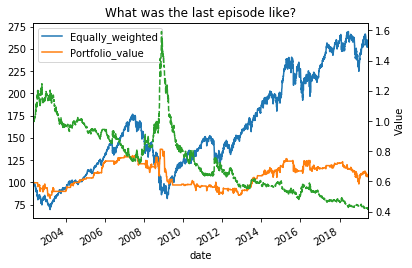

In [81]:
env.envs[0].plot_last_episode(save=False)

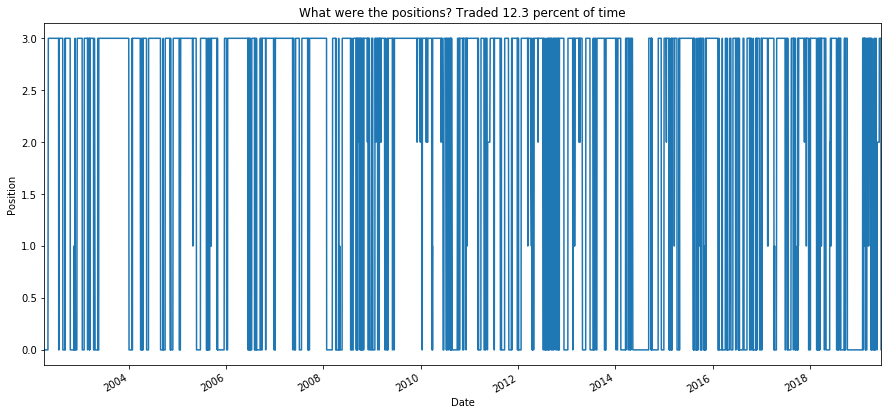

In [82]:
env.envs[0].plot_positions(save=False)

In [ ]:
env.envs[0].df_render.tail()